In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import dynamic_feature_last_position_taken

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    # build_features, 
    # build_rolling_feature
    FeatureEngineering
)

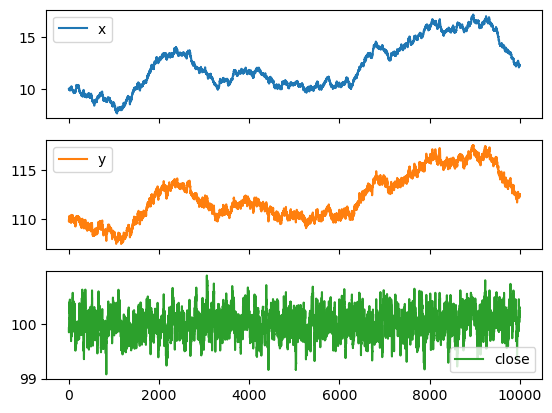

In [22]:
x, y = stationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [23]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 9.793e+05
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:13:55   Log-Likelihood:                 141.67
No. Observations:               10000   AIC:                            -279.3
Df Residuals:                    9998   BIC:                            -264.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.9159      0.013   7897.308      0.0

In [24]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -21.064022900913574
p-value: 0.0
Is the spread stationary? Yes


In [25]:
# build features
df_train = df.copy()

feature_config = {
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "diff", # difference between current and previous close price
    "subtract_mean": False, # subtract mean from the window
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,9.966343,109.889566,99.923223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.932413,109.780133,99.847721,-0.075502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,9.908252,109.784627,99.876374,0.028654,-0.075502,0.000000,0.000000,0.000000,0.000000,0.000000
3,9.914264,109.913011,99.998747,0.122373,0.028654,-0.075502,0.000000,0.000000,0.000000,0.000000
4,9.915529,109.926962,100.011433,0.012685,0.122373,0.028654,-0.075502,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
9995,12.275818,112.487349,100.211531,0.043968,-0.070790,0.066715,0.074191,0.024335,0.030349,-0.075309
9996,12.261953,112.424597,100.162644,-0.048887,0.043968,-0.070790,0.066715,0.074191,0.024335,0.030349
9997,12.182754,112.378310,100.195556,0.032912,-0.048887,0.043968,-0.070790,0.066715,0.074191,0.024335
9998,12.193735,112.501892,100.308157,0.112602,0.032912,-0.048887,0.043968,-0.070790,0.066715,0.074191


In [26]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0. 0. 0. 0. 0.]
Market Return :  0.38%   |   Portfolio Return : -59.34%   |   Position Changes : 6624   |   Episode Length : 10000   |   


In [27]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  0.38%   |   Portfolio Return : -45.21%   |   Position Changes : 5976   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : -3.56%   |   Position Changes : 4202   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : 12.91%   |   Position Changes : 3949   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return :  8.60%   |   Position Changes : 3915   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return :  8.46%   |   Position Changes : 4009   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : 15.20%   |   Position Changes : 3953   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return :  9.86%   |   Position Changes : 3866   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : 20.45%   |   Position Changes : 3971   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Po

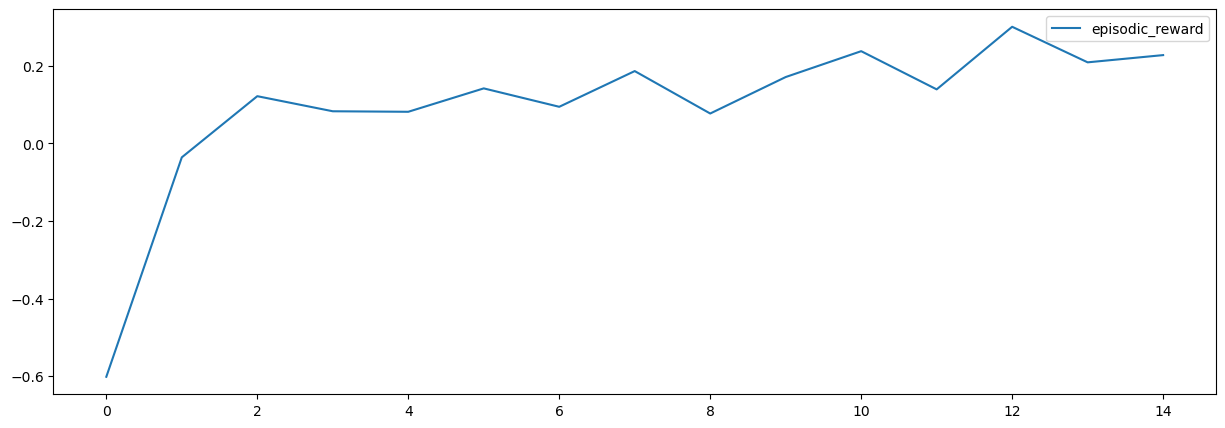

In [28]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [29]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df, main_feature_col="close")
    fe.rolling_feature(**feature_config)
    _df = fe.df.copy()
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            dynamic_feature_functions = [],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.25%   |   Portfolio Return : 14.08%   |   Position Changes : 4265   |   Episode Length : 10000   |   
Market Return :  0.18%   |   Portfolio Return : 13.46%   |   Position Changes : 4243   |   Episode Length : 10000   |   
Market Return : -0.15%   |   Portfolio Return :  5.27%   |   Position Changes : 4223   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return :  9.73%   |   Position Changes : 4135   |   Episode Length : 10000   |   
Market Return :  0.50%   |   Portfolio Return :  9.48%   |   Position Changes : 4335   |   Episode Length : 10000   |   
Market Return : -0.06%   |   Portfolio Return : -0.08%   |   Position Changes : 4312   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 11.94%   |   Position Changes : 4240   |   Episode Length : 10000   |   
Market Return : -0.08%   |   Portfolio Return : 30.50%   |   Position Changes : 4299   |   Episode Length : 10000   |   
Market Return :  0.46%   |   Por

In [30]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()

In [31]:
# build features
df_train = df.copy()

feature_config = {
    "window": 1, # 7 days window, pad with first value when window is not available
    "mode": "diff" # difference between current and previous close price
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_rolling_0
0,9.966343,109.889566,99.923223,0.000000
1,9.932413,109.780133,99.847721,-0.075502
2,9.908252,109.784627,99.876374,0.028654
3,9.914264,109.913011,99.998747,0.122373
4,9.915529,109.926962,100.011433,0.012685
...,...,...,...,...
9995,12.275818,112.487349,100.211531,0.043968
9996,12.261953,112.424597,100.162644,-0.048887
9997,12.182754,112.378310,100.195556,0.032912
9998,12.193735,112.501892,100.308157,0.112602


In [32]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1. -1.]
Market Return :  0.38%   |   Portfolio Return : -0.38%   |   Position Changes : 0   |   Episode Length : 10000   |   


In [33]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.38%   |   Portfolio Return : -60.38%   |   Position Changes : 6673   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : -58.23%   |   Position Changes : 6700   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : -47.13%   |   Position Changes : 5974   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : -43.97%   |   Position Changes : 5987   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : -22.75%   |   Position Changes : 5048   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : -20.73%   |   Position Changes : 5135   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : -12.55%   |   Position Changes : 4494   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : -18.43%   |   Position Changes : 4365   |   Episode Length : 10000   |   
Market Return :  0.38%  

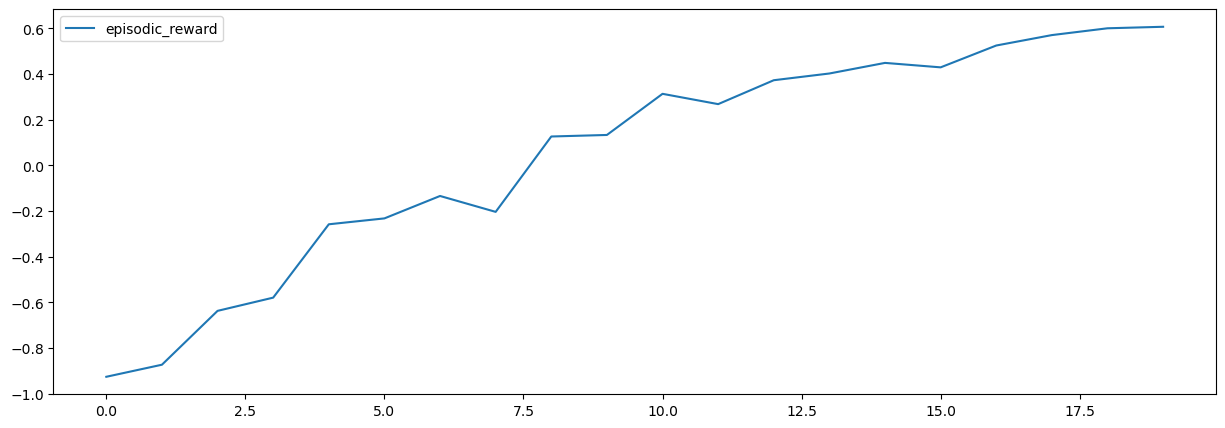

In [34]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [35]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df, main_feature_col="close")
    fe.rolling_feature(**feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.12%   |   Portfolio Return : 48.47%   |   Position Changes : 1768   |   Episode Length : 10000   |   
Market Return :  0.54%   |   Portfolio Return : 35.83%   |   Position Changes : 1682   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : 43.55%   |   Position Changes : 1933   |   Episode Length : 10000   |   
Market Return :  0.05%   |   Portfolio Return : 22.30%   |   Position Changes : 1604   |   Episode Length : 10000   |   
Market Return : -0.04%   |   Portfolio Return : 35.44%   |   Position Changes : 1679   |   Episode Length : 10000   |   
Market Return :  0.58%   |   Portfolio Return : 29.66%   |   Position Changes : 1533   |   Episode Length : 10000   |   
Market Return :  0.29%   |   Portfolio Return : 50.72%   |   Position Changes : 1591   |   Episode Length : 10000   |   
Market Return :  0.12%   |   Portfolio Return : 43.60%   |   Position Changes : 1708   |   Episode Length : 10000   |   
Market Return :  0.07%   |   Por